## Classification of Anomalies  in Gastrointestinal Tract through Endoscopic Imagery with Deep Learning

### Transfer learning using InceptionV3 model

#### Download kvasir-dataset-v2

In [ ]:
!wget --no-check-certificate \
  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip\
  -O /tmp/kvasir-dataset-v2.zip

--2021-03-16 07:41:37--  https://datasets.simula.no/kvasir/data/kvasir-dataset-v2.zip
Resolving datasets.simula.no (datasets.simula.no)... 128.39.36.14
Connecting to datasets.simula.no (datasets.simula.no)|128.39.36.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2489312085 (2.3G) [application/zip]
Saving to: ‘/tmp/kvasir-dataset-v2.zip’

/tmp/kvasir-dataset 100%[===================>]   2.32G  9.90MB/s    in 3m 56s  

2021-03-16 07:45:34 (10.1 MB/s) - ‘/tmp/kvasir-dataset-v2.zip’ saved [2489312085/2489312085]



#### Extract Data from zip file

In [ ]:
import os
import zipfile

zip_file = '/tmp/kvasir-dataset-v2.zip'

zip_ref = zipfile.ZipFile(zip_file, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense
from keras.utils import get_file
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

#### Generate data from local kvasir-dataset

In [ ]:
path ='/tmp/kvasir-dataset-v2'

image_gen = ImageDataGenerator(
    rescale=1/255,fill_mode='nearest', 
    brightness_range= [0.4,1],
    validation_split = 0.2,
    zoom_range=0.2,)

train_generator = image_gen.flow_from_directory(
    path,
    target_size=(224,224),
    batch_size=32,
    subset="training",
    seed=1337,
    class_mode='categorical'
)

validation_generator = image_gen.flow_from_directory(
    path,
    target_size=(224,224),
    batch_size=32,
    subset="validation",
    seed=1337,
    class_mode='categorical'
)


Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.


#### Instantiates the InceptionV3 architecture

In [ ]:
inception_model = InceptionV3(input_shape=(224, 224, 3),
                                include_top=False,
                                weights='imagenet')

for layer in inception_model.layers[:40]:
        layer.trainable = False
for layer in inception_model.layers[40:]:
        layer.trainable = True

last_layer = inception_model.get_layer('mixed7')
last_output = last_layer.output

In [ ]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(8, activation='softmax')(x)

model =  tf.keras.Model( inception_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

#### Training model

In [ ]:
epochs = 50

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 5,
            epochs = epochs,
            validation_steps = 5,
            verbose = 1)

Epoch 1/50
5/5 [==============================] - 17s 3s/step - loss: 3.1678 - accuracy: 0.1919 - val_loss: 2.1935 - val_accuracy: 0.2500
Epoch 2/50
5/5 [==============================] - 10s 2s/step - loss: 1.7779 - accuracy: 0.3085 - val_loss: 1.2267 - val_accuracy: 0.6062
Epoch 3/50
5/5 [==============================] - 9s 2s/step - loss: 1.1084 - accuracy: 0.6329 - val_loss: 1.1986 - val_accuracy: 0.6062
Epoch 4/50
5/5 [==============================] - 10s 2s/step - loss: 1.0837 - accuracy: 0.5772 - val_loss: 1.2571 - val_accuracy: 0.6313
Epoch 5/50
5/5 [==============================] - 10s 2s/step - loss: 0.7419 - accuracy: 0.7802 - val_loss: 1.2199 - val_accuracy: 0.5625
Epoch 6/50
5/5 [==============================] - 9s 2s/step - loss: 0.4371 - accuracy: 0.8510 - val_loss: 1.0797 - val_accuracy: 0.6625
Epoch 7/50
5/5 [==============================] - 10s 2s/step - loss: 0.5066 - accuracy: 0.8505 - val_loss: 1.0214 - val_accuracy: 0.6875
Epoch 8/50
5/5 [====================

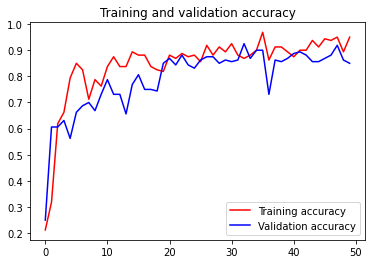

<Figure size 432x288 with 0 Axes>

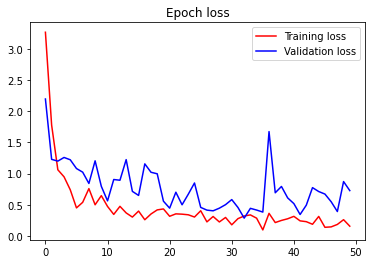

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Epoch loss')
plt.legend(loc=0)
plt.figure()
plt.show()